DATA CLEANING MODULE 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def load_nifty500_data(csv_path):
    """
    Load Nifty 500 data from CSV file matching your format
    """
    # Read CSV with correct parsing
    data = pd.read_csv(csv_path, thousands=',')  # Handles numbers with commas

    # Clean column names (remove ▼ symbols if present)
    data.columns = data.columns.str.replace(' ▼', '')

    # Convert date column to datetime
    data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

    # Convert Volume from string (like 3.24B) to numeric
    if 'Vol.' in data.columns:
        def convert_volume(v):
            if isinstance(v, str):
                if 'M' in v:
                    return float(v.replace('M', '')) * 1_000_000
                elif 'B' in v:
                    return float(v.replace('B', '')) * 1_000_000_000
                else:
                    return float(v)
            return v

        data['Vol.'] = data['Vol.'].apply(convert_volume)

    # Set date as index and sort
    data.set_index('Date', inplace=True)
    data.sort_index(inplace=True)

    # Rename 'Price' to 'Close' for consistency with standard naming
    data.rename(columns={'Price': 'Close'}, inplace=True)

    return data



SUPPORT LOGIC MODULE

In [7]:


def test_sma_support(data, sma_periods=range(40, 61), threshold_pct=0.005):
    """
    Test which SMA period acts as best support between 40-60 periods
    """
    results = {}
    data_with_smas = data.copy()

    # Calculate SMAs
    for period in sma_periods:
        data_with_smas[f'SMA_{period}'] = data_with_smas['Close'].rolling(window=period).mean()

    # Test each SMA period
    for period in sma_periods:
        sma_col = f'SMA_{period}'
        near_sma = abs(data_with_smas['Close'] - data_with_smas[sma_col]) / data_with_smas[sma_col] <= threshold_pct
        touch_dates = data_with_smas[near_sma].index

        bounce_window = 5  # 5 trading days to confirm bounce
        successful_bounces = 0

        for touch_date in touch_dates:
            try:
                touch_idx = data_with_smas.index.get_loc(touch_date)
                if touch_idx + bounce_window >= len(data_with_smas):
                    continue

                touch_price = data_with_smas.loc[touch_date, 'Close']
                future_prices = data_with_smas.iloc[touch_idx+1:touch_idx+bounce_window+1]['Close']

                if (future_prices > touch_price * (1 + threshold_pct)).any():
                    successful_bounces += 1
            except:
                continue

        total_touches = len(touch_dates)
        success_rate = successful_bounces / total_touches if total_touches > 0 else 0

        results[period] = {
            'success_rate': success_rate,
            'total_touches': total_touches,
            'successful_bounces': successful_bounces
        }

    return results, data_with_smas

PLOT/ANALYSIS MODULE 


SMA Support Effectiveness for Nifty 500 (40-60 periods):
+--------------+----------------+----------------+----------------------+
|   SMA Period | Success Rate   |   Touch Events |   Successful Bounces |
+==============+================+================+======================+
|           10 | 64.5%          |            217 |                  140 |
+--------------+----------------+----------------+----------------------+
|           15 | 61.1%          |            167 |                  102 |
+--------------+----------------+----------------+----------------------+
|           20 | 58.2%          |            146 |                   85 |
+--------------+----------------+----------------+----------------------+
|           25 | 50.0%          |            112 |                   56 |
+--------------+----------------+----------------+----------------------+
|           30 | 53.5%          |             99 |                   53 |
+--------------+----------------+----------------+----

C:\Users\acer\AppData\Local\Temp\ipykernel_19304\230282821.py:29: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  plot_data = data_with_smas.last('5Y')  # Last 5 years
C:\Users\acer\AppData\Local\Temp\ipykernel_19304\230282821.py:29: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plot_data = data_with_smas.last('5Y')  # Last 5 years


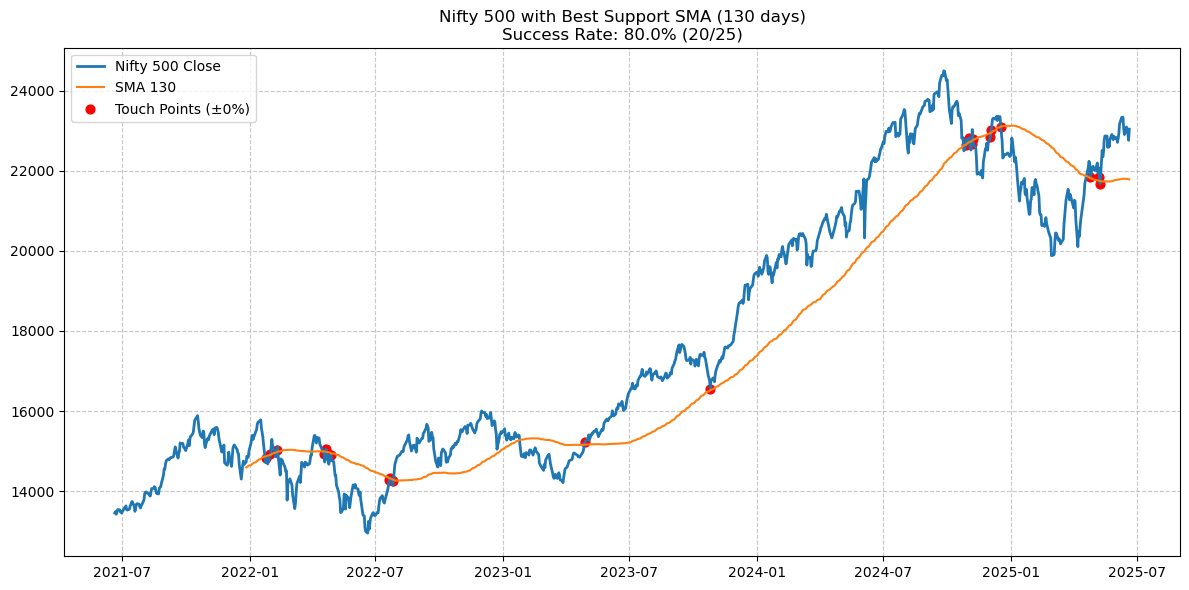

In [16]:
def analyze_sma_support(csv_path):
    # Load and prepare data
    data = load_nifty500_data(csv_path)

    # Test SMAs between 20-200 periods (increment by 1)
    sma_periods = range(10, 205, 5)
    results, data_with_smas = test_sma_support(data, sma_periods)

    # Display results
    print("\nSMA Support Effectiveness for Nifty 500 (40-60 periods):")
    result_table = []
    for period, stats in results.items():
        result_table.append([
            period,
            f"{stats['success_rate']:.1%}",
            stats['total_touches'],
            stats['successful_bounces']
        ])

    print(tabulate(result_table,
                  headers=['SMA Period', 'Success Rate', 'Touch Events', 'Successful Bounces'],
                  tablefmt='grid'))

    # Visualize
    if results:
        best_sma = max(results.items(), key=lambda x: x[1]['success_rate'])[0]

        plt.figure(figsize=(12, 6))
        plot_data = data_with_smas.last('5Y')  # Last 5 years

        # Plot price and SMA
        plt.plot(plot_data['Close'], label='Nifty 500 Close', color='#1f77b4', linewidth=2)
        plt.plot(plot_data[f'SMA_{best_sma}'], label=f'SMA {best_sma}', color='#ff7f0e', linewidth=1.5)

        # Mark touch points
        threshold = 0.005
        near_sma = abs(plot_data['Close'] - plot_data[f'SMA_{best_sma}']) / plot_data[f'SMA_{best_sma}'] <= threshold
        touch_points = plot_data[near_sma]
        plt.scatter(touch_points.index, touch_points['Close'],
                   color='red', s=40, label=f'Touch Points (±{threshold:.0%})')

        plt.title(f'Nifty 500 with Best Support SMA ({best_sma} days)\n'
                 f'Success Rate: {results[best_sma]["success_rate"]:.1%} '
                 f'({results[best_sma]["successful_bounces"]}/{results[best_sma]["total_touches"]})')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    return results, data_with_smas

if __name__ == "__main__":
    csv_path = "Documents/Nifty 500 Historical Data.csv"  # <-- put your real path or filename here
    results, _ = analyze_sma_support(csv_path)

REINFORCEMENT LEARNING MODULE


=== Reinforcement Learning Optimization Results ===
Optimal SMA Period: 45

Normalized Results:
   SMA_Period  Norm_Success  Norm_Touches
0          10      0.657568      1.000000
1          15      0.581529      0.739583
2          20      0.518309      0.630208
3          25      0.336538      0.453125
4          30      0.414724      0.385417

Q-table (first 5 rows):
[[7.26054591 7.14763138]
 [7.26054591 6.97355691]
 [7.14763138 6.673291  ]
 [6.97355691 7.01990173]
 [6.67592593 7.34560031]]


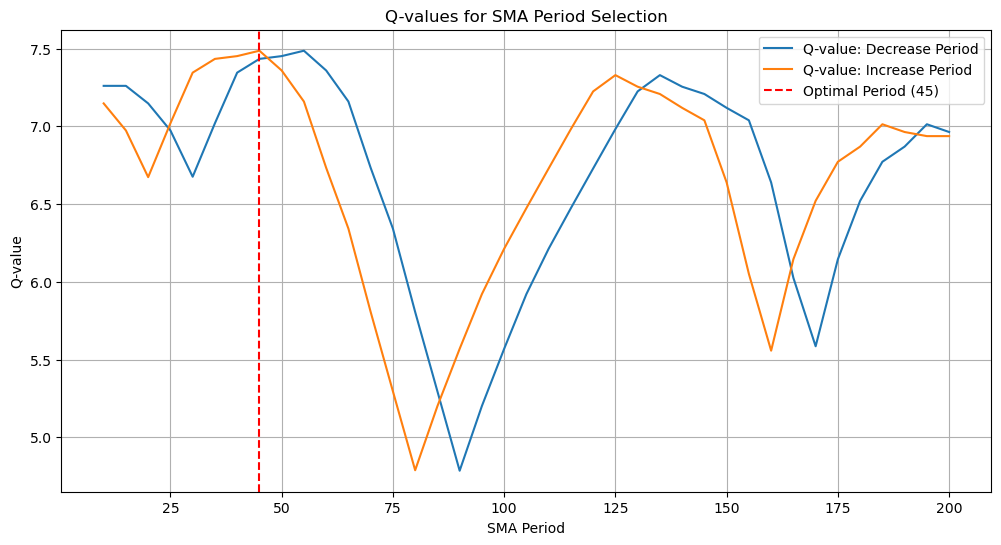

In [31]:
# First, let's get the results DataFrame from previous analysis
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['SMA_Period', 'Success_Rate', 'Touch_Events', 'Successful_Bounces']
results_df = results_df.sort_values('SMA_Period')

# Reinforcement Learning Optimization
def optimize_sma_with_rl(results_df, learning_rate=0.1, discount_factor=0.9, epochs=10000, exploration_rate=0.3):
    """
    Optimize SMA period selection using Q-learning
    Args:
        results_df: DataFrame containing SMA test results
        learning_rate: How quickly the algorithm learns (0-1)
        discount_factor: Importance of future rewards (0-1)
        epochs: Number of training iterations
        exploration_rate: Probability of random exploration (0-1)
    Returns:
        Tuple of (best_period, Q_table, normalized_results)
    """
    # Normalize our metrics (0-1 range)
    results_df['Norm_Success'] = (results_df['Success_Rate'] - results_df['Success_Rate'].min()) / \
                                (results_df['Success_Rate'].max() - results_df['Success_Rate'].min())
    results_df['Norm_Touches'] = (results_df['Touch_Events'] - results_df['Touch_Events'].min()) / \
                                (results_df['Touch_Events'].max() - results_df['Touch_Events'].min())

    # States are SMA periods (40-60)
    states = results_df['SMA_Period'].values
    n_states = len(states)

    # Actions: 0 = decrease period, 1 = increase period
    actions = [0, 1]
    n_actions = len(actions)

    # Initialize Q-table
    Q = np.zeros((n_states, n_actions))

    # Reward function - weighted combination of success rate and touch frequency
    def get_reward(state_idx, action):
        current_period = states[state_idx]
        if action == 0:  # Decrease period
            new_state_idx = max(0, state_idx - 1)
        else:  # Increase period
            new_state_idx = min(n_states - 1, state_idx + 1)

        new_period = states[new_state_idx]
        row = results_df[results_df['SMA_Period'] == new_period].iloc[0]

        # Reward balances success rate (70%) and touch frequency (30%)
        reward = 0.8 * row['Norm_Success'] + 0.2 * row['Norm_Touches']
        return reward, new_state_idx

    # Q-learning algorithm
    for epoch in range(epochs):
        state_idx = np.random.randint(0, n_states)  # Random initial state
        for _ in range(10):  # Run 10 steps per epoch
            if np.random.uniform(0, 1) < exploration_rate:
                action = np.random.choice(actions)  # Explore
            else:
                action = np.argmax(Q[state_idx, :])  # Exploit

            reward, new_state_idx = get_reward(state_idx, action)

            # Bellman equation update
            Q[state_idx, action] = (1 - learning_rate) * Q[state_idx, action] + \
                                  learning_rate * (reward + discount_factor * np.max(Q[new_state_idx, :]))

            state_idx = new_state_idx

    # Find best period (state with highest max Q-value)
    best_state_idx = np.argmax(np.max(Q, axis=1))
    best_period = states[best_state_idx]

    return best_period, Q, results_df

# Run the optimization
best_period, Q_table, normalized_results = optimize_sma_with_rl(results_df)

# Display results
print("\n=== Reinforcement Learning Optimization Results ===")
print(f"Optimal SMA Period: {best_period}")
print("\nNormalized Results:")
print(normalized_results[['SMA_Period', 'Norm_Success', 'Norm_Touches']].head())

print("\nQ-table (first 5 rows):")
print(Q_table[:5])

# Visualize the Q-values
plt.figure(figsize=(12, 6))
plt.plot(normalized_results['SMA_Period'], Q_table[:, 0], label='Q-value: Decrease Period')
plt.plot(normalized_results['SMA_Period'], Q_table[:, 1], label='Q-value: Increase Period')
plt.axvline(x=best_period, color='r', linestyle='--', label=f'Optimal Period ({best_period})')
plt.title('Q-values for SMA Period Selection')
plt.xlabel('SMA Period')
plt.ylabel('Q-value')
plt.legend()
plt.grid(True)
plt.show()

BEST PERIOD PLT MODULE 

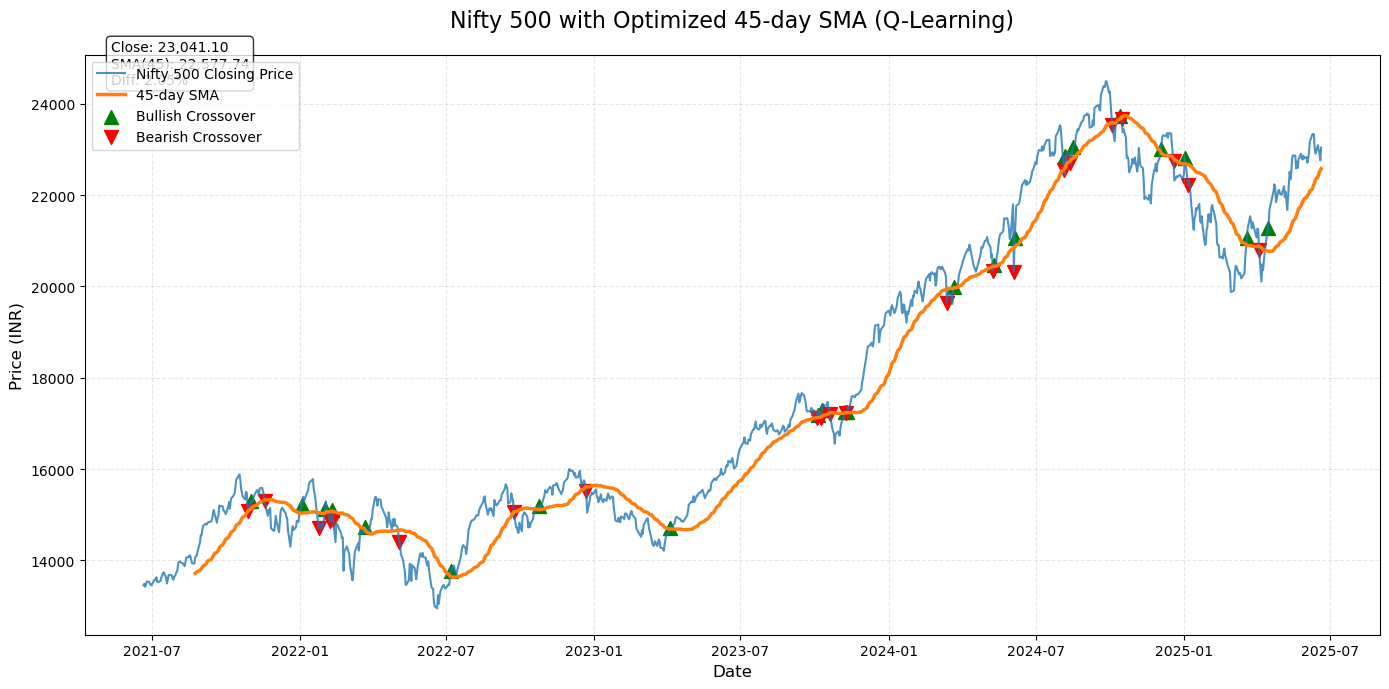


SMA(45) Crossover Stats:
First valid SMA date: 2021-08-24
Latest SMA value: 22,577.74
Bullish crossovers: 22
Bearish crossovers: 22


In [32]:
# 1. Load and clean data
nifty_data = load_nifty500_data('Documents/Nifty 500 Historical Data.csv')

# 2. Calculate SMA using the optimized best_period
sma_column = f'SMA_{best_period}'
nifty_data[sma_column] = nifty_data['Close'].rolling(window=best_period).mean()

# 3. Identify crossovers
cross_up = (nifty_data['Close'].shift(1) < nifty_data[sma_column].shift(1)) & (nifty_data['Close'] > nifty_data[sma_column])
cross_down = (nifty_data['Close'].shift(1) > nifty_data[sma_column].shift(1)) & (nifty_data['Close'] < nifty_data[sma_column])

# 4. Plot the chart
plt.figure(figsize=(14, 7))
plt.plot(nifty_data.index, nifty_data['Close'], label='Nifty 500 Closing Price', color='#1f77b4', alpha=0.8, linewidth=1.5)
plt.plot(nifty_data.index, nifty_data[sma_column], label=f'{best_period}-day SMA', color='#ff7f0e', linewidth=2.5)

plt.scatter(nifty_data[cross_up].index, nifty_data[cross_up]['Close'], color='green', marker='^', s=100, label='Bullish Crossover')
plt.scatter(nifty_data[cross_down].index, nifty_data[cross_down]['Close'], color='red', marker='v', s=100, label='Bearish Crossover')

plt.title(f'Nifty 500 with Optimized {best_period}-day SMA (Q-Learning)', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (INR)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)

# Annotate SMA stats
last_sma = nifty_data[sma_column].iloc[-1]
last_close = nifty_data['Close'].iloc[-1]
plt.annotate(f'Close: {last_close:,.2f}\nSMA({best_period}): {last_sma:,.2f}\nDiff: {(last_close - last_sma)/last_sma:.2%}',
             xy=(0.02, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# 5. Print crossover stats
print(f"\nSMA({best_period}) Crossover Stats:")
print(f"First valid SMA date: {nifty_data[sma_column].first_valid_index().strftime('%Y-%m-%d')}")
print(f"Latest SMA value: {last_sma:,.2f}")
print(f"Bullish crossovers: {cross_up.sum()}")
print(f"Bearish crossovers: {cross_down.sum()}")
